In [ ]:
!pip install datasets

In [ ]:
!pip install tensorflow

In [3]:
from google.colab import drive
drive.mount('/content/drive')


from datasets import load_dataset
voice_emotion_dataset = load_dataset('Aniemore/resd')

voice_emotion_dataset.save_to_disk("resd_dataset.hf")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1116 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/280 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1116 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/280 [00:00<?, ? examples/s]

In [5]:
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset


# Load audio files and extract features
def extract_features(audio, sr=16000):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    return np.mean(mfccs, axis=1)

# Define emotions and corresponding labels
emotions = ['enthusiasm', 'happiness', 'neutral', 'sadness', 'disgust', 'fear', 'anger']
labels = list(range(len(emotions)))

# Load and preprocess data
X_train = []
y_train = []
X_test = []
y_test = []


# Function to load and process data from the dataset
def load_and_process_data(dataset, X, y):
    for label, emotion in enumerate(emotions):
        for example in dataset:
            if example['emotion'] == emotion:
                audio_dict = example['speech']
                audio_array = audio_dict['array']
                # Assuming 'array' is the correct key for audio data
                audio = np.array(audio_array)
                sr = audio_dict['sampling_rate']
                features = extract_features(audio, sr=sr)
                X.append(features)
                y.append(label)


voice_emotion_dataset = load_dataset('Aniemore/resd')
train_dataset = voice_emotion_dataset['train']
test_dataset = voice_emotion_dataset['test']
# Load and preprocess training data
load_and_process_data(train_dataset, X_train, y_train)

# Convert lists to numpy arrays and concatenate features
if X_train:
    X_train = np.vstack(X_train)


Теперь попробуем обучить LSTM модель.

In [6]:
# Импорт библиотек
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Преобразование данных для входа в LSTM
X_train_lstm = np.expand_dims(X_train, axis=-1)

# Разделение данных на обучающий и валидационный наборы
X_train_lstm, X_val_lstm, y_train, y_val = train_test_split(X_train_lstm, y_train, test_size=0.2, random_state=42)

# Преобразование эмоциональных меток в формат one-hot
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_train_categorical = to_categorical(y_train_encoded, num_classes=len(emotions))
y_val_categorical = to_categorical(y_val_encoded, num_classes=len(emotions))

# Создание модели LSTM
model = models.Sequential()
model.add(layers.LSTM(units=50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(layers.Dense(len(emotions), activation='softmax'))

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train_lstm, y_train_categorical, epochs=10, validation_data=(X_val_lstm, y_val_categorical))


Epoch 1/10
28/28 [==============================] - 3s 29ms/step - loss: 1.9361 - accuracy: 0.1738 - val_loss: 1.8823 - val_accuracy: 0.2188
Epoch 2/10
28/28 [==============================] - 0s 9ms/step - loss: 1.8669 - accuracy: 0.2287 - val_loss: 1.8300 - val_accuracy: 0.2589
Epoch 3/10
28/28 [==============================] - 0s 10ms/step - loss: 1.8193 - accuracy: 0.2466 - val_loss: 1.7936 - val_accuracy: 0.2455
Epoch 4/10
28/28 [==============================] - 0s 9ms/step - loss: 1.7928 - accuracy: 0.2601 - val_loss: 1.7795 - val_accuracy: 0.2589
Epoch 5/10
28/28 [==============================] - 0s 10ms/step - loss: 1.7736 - accuracy: 0.2993 - val_loss: 1.7696 - val_accuracy: 0.2723
Epoch 6/10
28/28 [==============================] - 0s 9ms/step - loss: 1.7561 - accuracy: 0.2960 - val_loss: 1.7639 - val_accuracy: 0.2857
Epoch 7/10
28/28 [==============================] - 0s 10ms/step - loss: 1.7412 - accuracy: 0.3128 - val_loss: 1.7525 - val_accuracy: 0.2723
Epoch 8/10
28/28

Теперь проверяем

9/9 [==============================] - 1s 5ms/step - loss: 1.7911 - accuracy: 0.3000
Test Loss: 1.7911019325256348, Test Accuracy: 0.30000001192092896


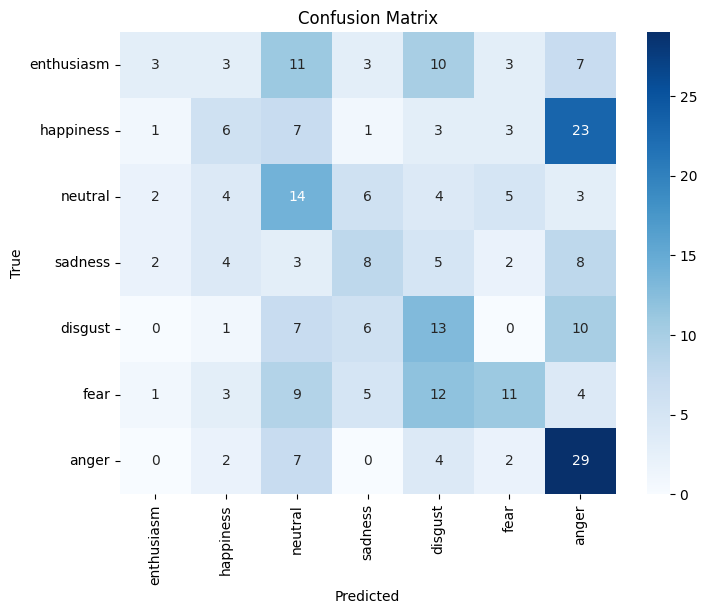

In [7]:
# Загрузка и предобработка тестовых данных
X_test = []
y_test = []

# Загрузка и обработка данных из тестового набора
load_and_process_data(test_dataset, X_test, y_test)

# Преобразование данных для входа в LSTM
X_test_lstm = np.expand_dims(np.vstack(X_test), axis=-1)

# Преобразование эмоциональных меток в формат one-hot для тестового набора
y_test_encoded = label_encoder.transform(y_test)
y_test_categorical = to_categorical(y_test_encoded, num_classes=len(emotions))

# Предсказание эмоций с использованием обученной модели
predictions = model.predict(X_test_lstm)

# Оценка результатов
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test_categorical)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Визуализация матрицы ошибок (confusion matrix)
y_pred_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_labels, labels=labels)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
